In [1]:
import sys
import yaml
import pathlib
import numpy
import pandas
import matplotlib.pyplot as plt
from monte_carlo_utils import make_bins, get_bin, place_into_bins

In [2]:
input_directory = pathlib.Path(
    '/Users/rmueller/Data/MIDOSS/marine_transport_data/'
)

### open master yaml file for 
with open(input_directory/'master.yaml') as file:
    master = yaml.load(file, Loader=yaml.Loader)

### load ATB data
atb_data_df = pandas.read_excel(
    master['files']['oil_capacity'],
    sheet_name='atb data', 
    usecols='A,B,C,D,E'
)    
    
# Get Total number of AIS pings and vessel length by MMSI for
# our different ship types
data = {}
data['count'] = {}
data['length'] = {}
length_bins = {}
for vessel in master['categories']['all_vessels']:
    input_data = pandas.read_excel(
        master['files']['oil_capacity'],
        sheet_name=f'{vessel} data', 
        usecols='B,C'
    )
    data['count'][vessel]  = input_data['COUNT']
    data['length'][vessel] = input_data['LENGTH']
    length_bins[vessel] = {}


In [3]:
# tanker
length_bins['tanker']['lower_bound'] = 0
length_bins['tanker']['upper_bound'] = 300
length_bins['tanker']['step_size']   = 50

# atb
length_bins['atb']['lower_bound'] = 0
length_bins['atb']['upper_bound'] = 300
length_bins['atb']['step_size']   = 50

# barge
length_bins['barge']['lower_bound'] = 0
length_bins['barge']['upper_bound'] = 100
length_bins['barge']['step_size']   = 10

# cargo
length_bins['cargo']['lower_bound'] = 200
length_bins['cargo']['upper_bound'] = 400
length_bins['cargo']['step_size']   = 25

# cruise
length_bins['cruise']['lower_bound'] = 250
length_bins['cruise']['upper_bound'] = 350
length_bins['cruise']['step_size']   = 10

# ferry
length_bins['ferry']['lower_bound'] = 35
length_bins['ferry']['upper_bound'] = 160
length_bins['ferry']['step_size']   = 10

# fishing
length_bins['fishing']['lower_bound'] = 0
length_bins['fishing']['upper_bound'] = 80
length_bins['fishing']['step_size']   = 10

# smallpass
length_bins['smallpass']['lower_bound'] = 0
length_bins['smallpass']['upper_bound'] = 35
length_bins['smallpass']['step_size']   = 5

# other
length_bins['other']['lower_bound'] = 0
length_bins['other']['upper_bound'] = 35
length_bins['other']['step_size']   = 5


### Plot ship tracks by vessel type and length

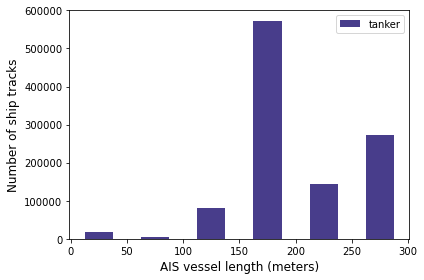

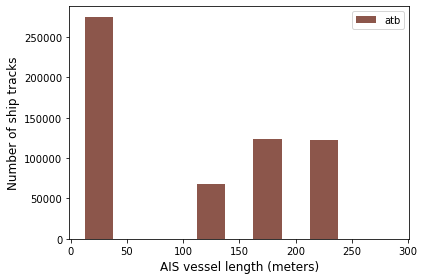

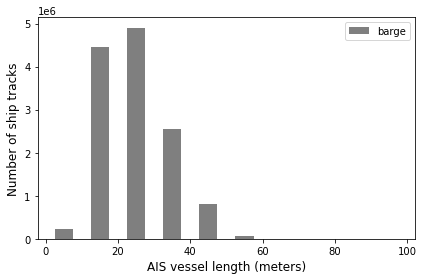

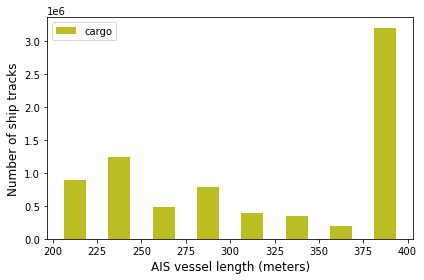

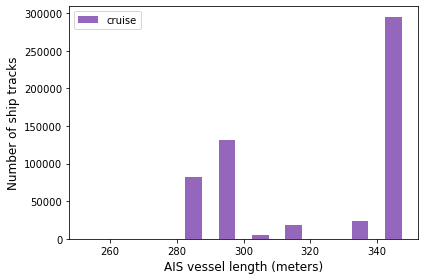

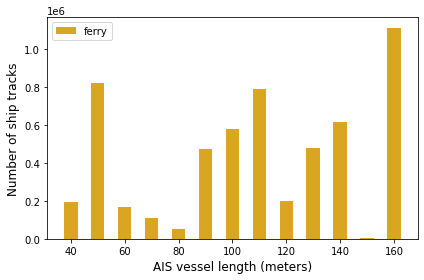

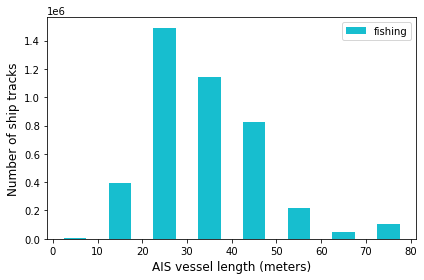

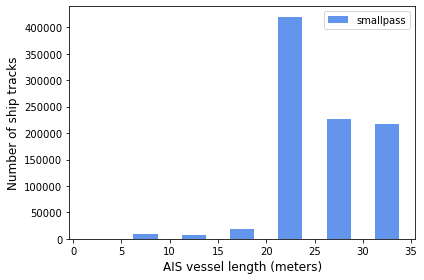

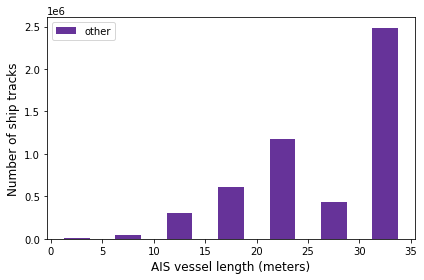

In [4]:
colors = ['darkslateblue', 'tab:brown', 
          'tab:gray', 'tab:olive',
          'tab:purple','goldenrod',
          'tab:cyan','cornflowerblue',
          'rebeccapurple']
color_index=0
for vessel in master['categories']['all_vessels']:

    lower_bound = length_bins[vessel]['lower_bound']
    upper_bound = length_bins[vessel]['upper_bound']
    step_size   = length_bins[vessel]['step_size']

    [bins, bin_centers]  = make_bins(
        lower_bound,
        upper_bound,
        step_size
    )

    binned_count = place_into_bins(
        data['length'][vessel], 
        data['count'][vessel], 
        bins
    )
    if vessel=='atb':
        atb_bin_centers = bin_centers
        atb_binned_count = binned_count

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.bar(
        bin_centers,
        binned_count,
        label=vessel,
        width = step_size/2,
        color=colors[color_index]
    )
    plt.xlabel('AIS vessel length (meters)',fontsize=12)
    plt.ylabel('Number of ship tracks',fontsize=12)
    plt.tight_layout()
    ax1.legend()
    plt.show() 
    
    color_index += 1

### Add all traffic to the same graphic

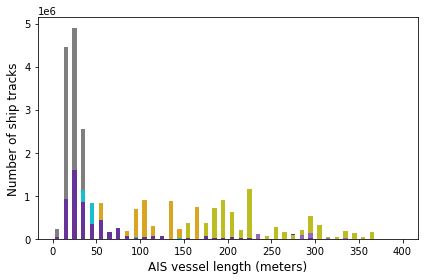

In [5]:
colors = ['darkslateblue', 'tab:brown', 
          'tab:gray', 'tab:olive',
          'tab:purple','goldenrod',
          'tab:cyan','cornflowerblue',
          'rebeccapurple']

color_index=0

[bins, bin_centers]  = make_bins(
    lower_bound = 0,
    upper_bound = 400,
    step_size   = 10
)

fig = plt.figure()
ax1 = fig.add_subplot(111)
length = len(bin_centers) 

for vessel in master['categories']['all_vessels']:
    
    binned_count = place_into_bins(
        data['length'][vessel], 
        data['count'][vessel], 
        bins
    )

    ax1.bar(
        bin_centers,
        binned_count,
        label=vessel,
        width = step_size,
        color=colors[color_index]
    )
    
    color_index += 1

plt.xlabel('AIS vessel length (meters)',fontsize=12)
plt.ylabel('Number of ship tracks',fontsize=12)
plt.tight_layout()
plt.show() 
ax1.legend()

### Scale ATB by time interval to see if/how it affects result
I still need to check that the result that all are scaling down is a good result and not a reflection that I made a mistake 

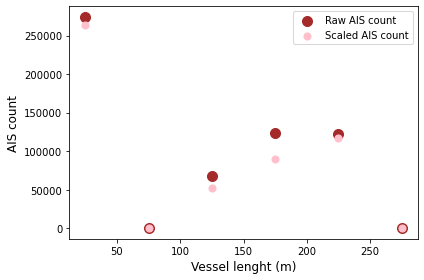

In [6]:
# scale tracks according to time interval between pings
atb_tracks = (atb_data_df['COUNT'] * 
     atb_data_df['Median time between pings (minutes)']/
     numpy.mean(atb_data_df['Median time between pings (minutes)'])
)

lower_bound = length_bins['atb']['lower_bound']
upper_bound = length_bins['atb']['upper_bound']
step_size   = length_bins['atb']['step_size']

[bins, bin_centers]  = make_bins(
    lower_bound,
    upper_bound,
    step_size
)

# place scaled tracks into length bins
binned_tracks = place_into_bins(
    atb_data_df['LENGTH'], 
    atb_tracks, 
    bins
)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(
    atb_bin_centers,
    atb_binned_count,
    100,
    label='Raw AIS count',
    color='brown'
)
ax1.scatter(
    bin_centers,
    binned_tracks,
    50,
    label='Scaled AIS count',
    color='pink'
)
plt.xlabel('Vessel lenght (m)',fontsize=12)
plt.ylabel('AIS count',fontsize=12)
plt.tight_layout()
ax1.legend()
plt.show()

### Show AIS pings multiplied by oil capacity

In [7]:
from get_oil_capacity import get_oil_capacity

random_seed=None
# Initialize PCG-64 random number generator
random_generator = numpy.random.default_rng(random_seed)
fuel = {}
cargo={}

# create lengths for calculating oil capacity
[bins, bin_centers]  = make_bins(
    lower_bound = 0,
    upper_bound = 400,
    step_size   = 10
)

# calculate oil capacity by length and vessel type
for vessel in master['categories']['all_vessels']:
    for length in bin_centers:
        [fuel_output,cargo_output] = get_oil_capacity(
            input_directory/'master.yaml', 
            length, 
            vessel, 
            random_generator
        )
        
        if vessel not in fuel:
            fuel[vessel]=[fuel_output]
            cargo[vessel]=[cargo_output]
        else:
            fuel[vessel].append(fuel_output)
            cargo[vessel].append(cargo_output)


### Calculated scaled values for AIS count

In [24]:
binned_count = {}
binned_count['raw'] = {}
binned_count['fuel_scaled'] = {}
binned_count['cargo_scaled'] = {}

for vessel in master['categories']['all_vessels']:
    
    binned_data = place_into_bins(
        data['length'][vessel], 
        data['count'][vessel], 
        bins
    )
    
    # store values
    binned_count['raw'][vessel] = binned_data
    
    # multiply counts in length bins by oil capacity in bin
    binned_count['fuel_scaled'][vessel] = binned_data * fuel[vessel] 
    binned_count['cargo_scaled'][vessel] = binned_data * cargo[vessel]
    
    # correct barge traffic to reflect 1 oil cargo barge for every ~10 barges. 
    if 'barge' in vessel:
        binned_count['cargo_scaled'][vessel] = binned_data * cargo[vessel]/10

### First plot by fuel oil capacity and length

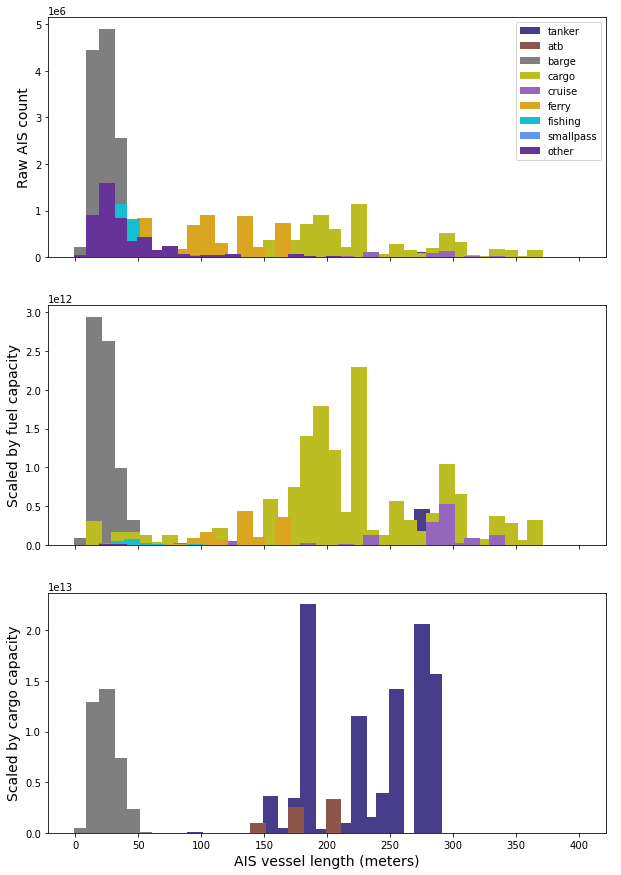

In [37]:
from textwrap import wrap
fs = 14
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

length = len(bin_centers) 
color_index=0
for vessel in master['categories']['all_vessels']:
    ax1.bar(
        bin_centers,
        binned_count['raw'][vessel],
        label=vessel,
        width = step_size/4,
        color=colors[color_index]
    )
    
    ax2.bar(
        bin_centers,
        binned_count['fuel_scaled'][vessel],
        label=vessel,
        width = step_size/4,
        color=colors[color_index]
    )
    
    ax3.bar(
        bin_centers,
        binned_count['cargo_scaled'][vessel],
        label=vessel,
        width = step_size/4,
        color=colors[color_index]
    )
    color_index += 1
    
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

# Set common labels
# ax.set_xlabel('common xlabel')
# ax.set_ylabel('common ylabel')

# Set specific plot labels
ax1.set_ylabel('Raw AIS count',fontsize=fs)
ax2.set_ylabel('Scaled by fuel capacity',fontsize=fs)
ax3.set_ylabel('Scaled by cargo capacity',fontsize=fs)
ax1.set_xticklabels('')
ax2.set_xticklabels('')

ax3.set_xlabel('AIS vessel length (meters)',fontsize=fs)

ax1.legend()

# plt.tight_layout()
# plt.show() 
# ax1.legend()
